In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
data=pd.read_excel('train_agriculture.xlsx')
data.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [3]:
data.describe(include='all')

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,4599,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4157.000000,4599.000000,4599.000000,4599.000000
unique,4599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,F00004777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1363.000435,0.224831,0.476625,2.283540,26.477495,28.891027,9.205479,1.894325,0.194390
std,NaN,814.439120,0.417517,0.499508,0.471978,15.524647,12.586005,9.713253,0.694952,0.454597
min,NaN,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,NaN,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,NaN,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,NaN,1786.000000,0.000000,1.000000,3.000000,40.000000,38.000000,16.000000,2.000000,0.000000


In [4]:
data.drop(['ID'],axis=1,inplace=True)

In [5]:
data.isnull().sum()

Estimated_Insects_Count      0
Crop_Type                    0
Soil_Type                    0
Pesticide_Use_Category       0
Number_Doses_Week            0
Number_Weeks_Used          442
Number_Weeks_Quit            0
Season                       0
Crop_Damage                  0
dtype: int64

In [6]:
data['Number_Weeks_Used'].fillna(value=data['Number_Weeks_Used'].mean(),inplace=True)
data.isnull().sum()

Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
dtype: int64

In [7]:
sns.set()

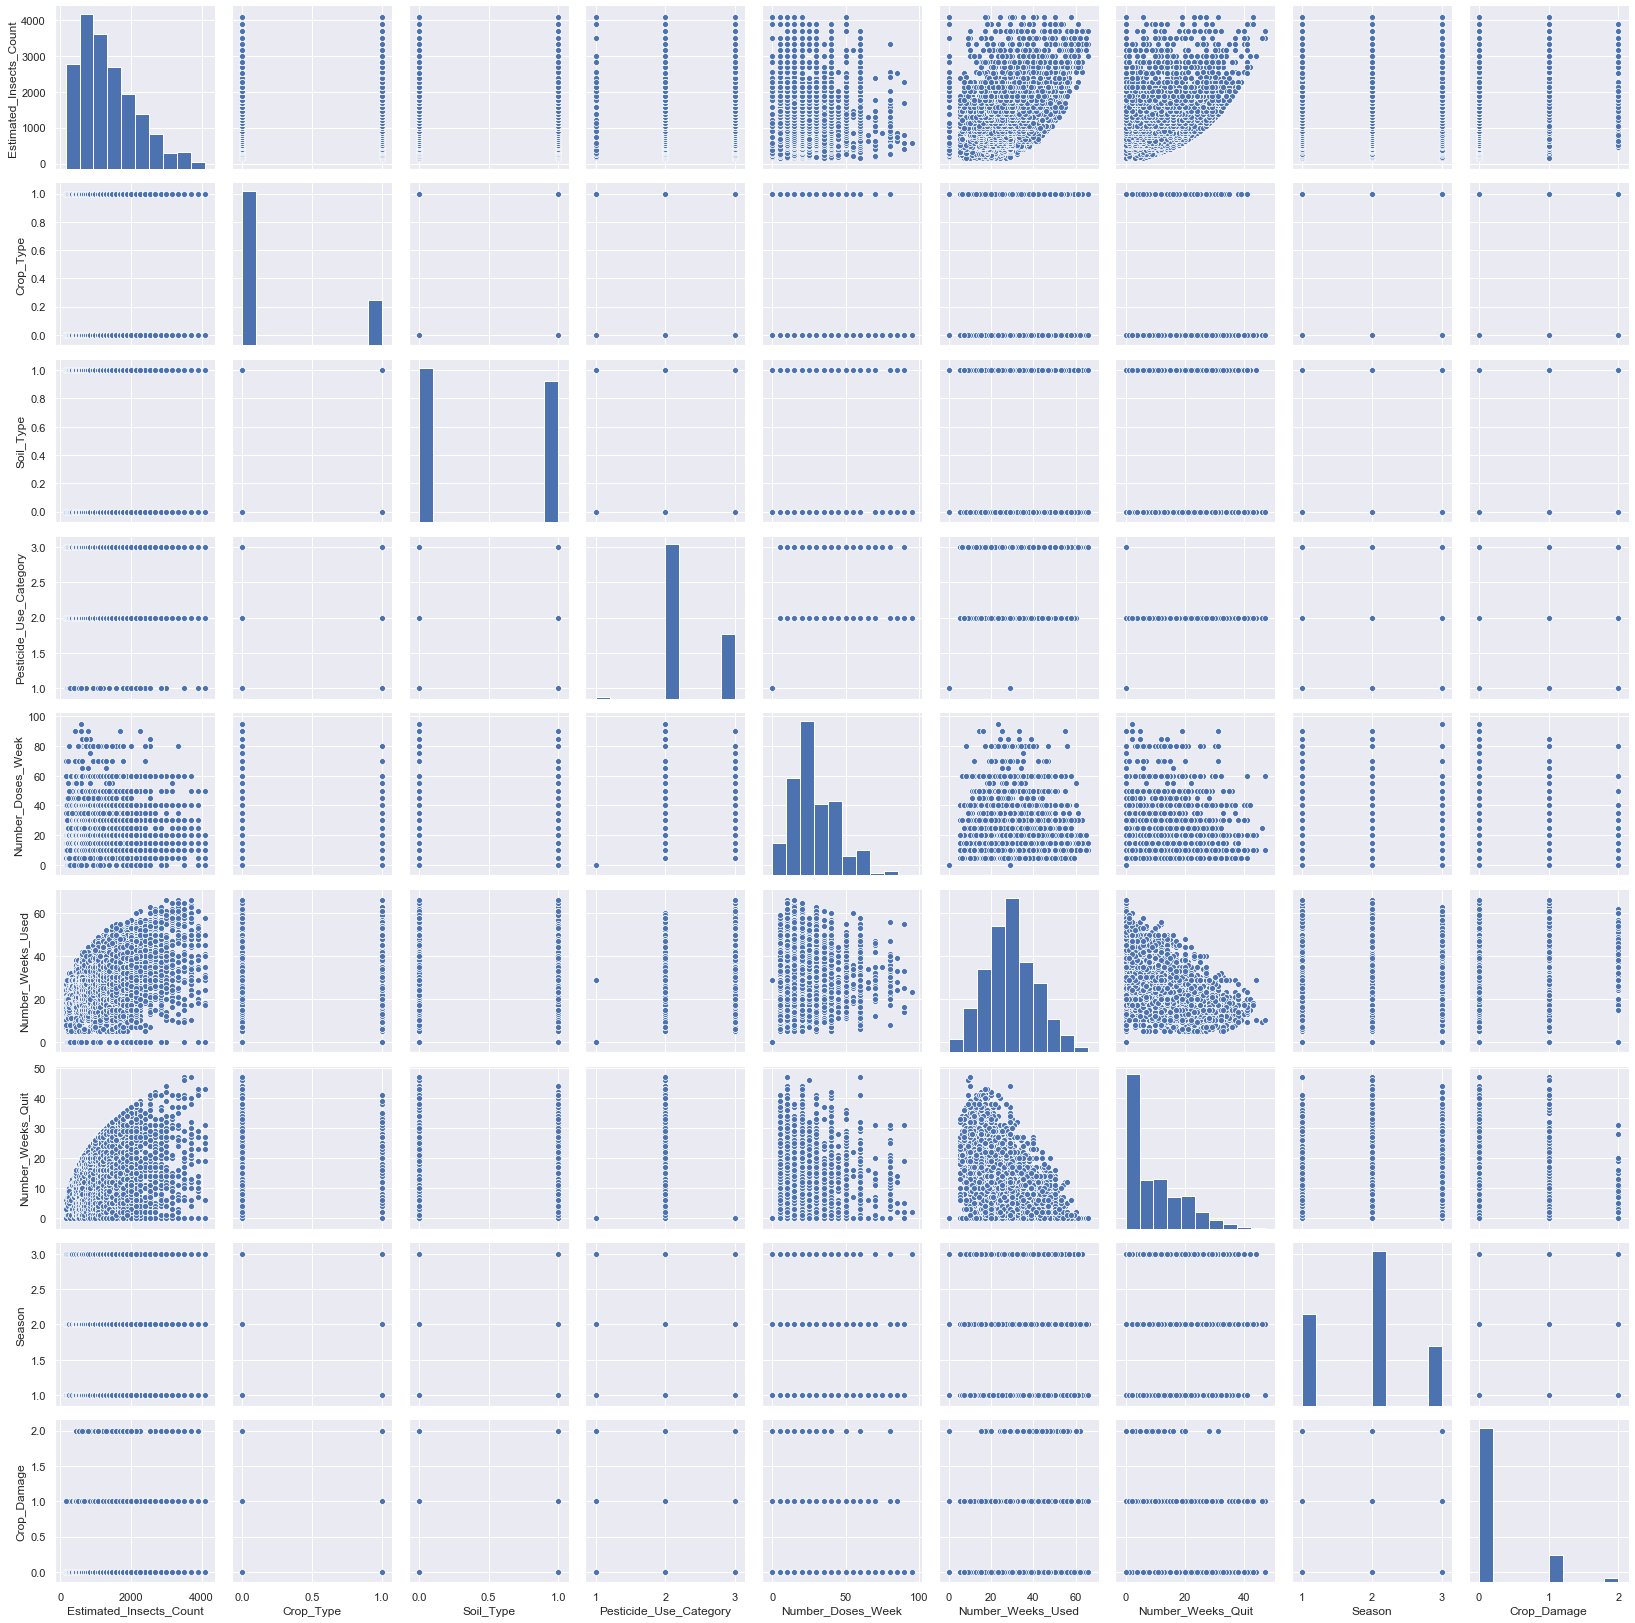

In [8]:
sns.pairplot(data)
plt.show()

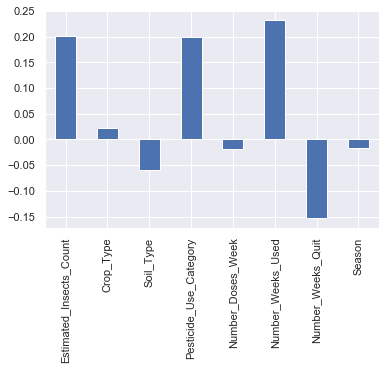

In [9]:
data.drop('Crop_Damage',axis=1).corrwith(data['Crop_Damage']).plot(kind='bar')
plt.show()

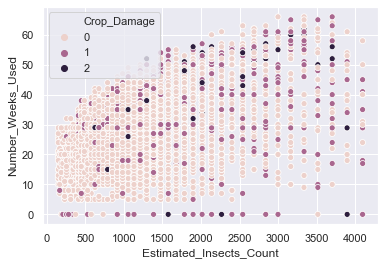

In [10]:
sns.scatterplot(data['Estimated_Insects_Count'],data['Number_Weeks_Used'],hue=data['Crop_Damage'])
plt.show()

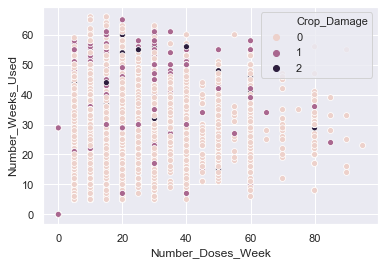

In [11]:
sns.scatterplot(data['Number_Doses_Week'],data['Number_Weeks_Used'],hue=data['Crop_Damage'])
plt.show()

In [12]:
cols = data.select_dtypes([np.number]).columns

In [13]:
from scipy.stats import zscore
z_score=abs(zscore(data[cols]))
print(data.shape)
data_final=data.loc[(z_score<3).all(axis=1)]
print(data_final.shape)

(4599, 9)
(4370, 9)


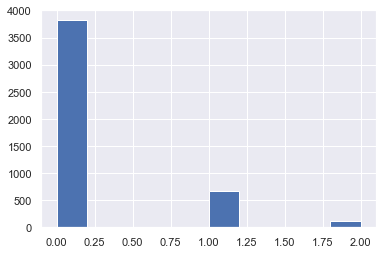

In [14]:
plt.hist(data['Crop_Damage'])
plt.show()

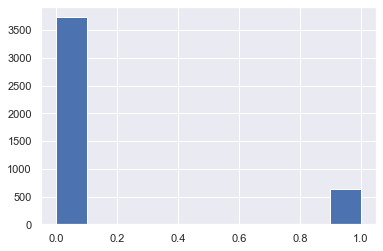

In [15]:
plt.hist(data_final['Crop_Damage'])
plt.show()

#### So removal of outlier removes all the '2' entries for the entire 'Crop_Damage' column. So we cannot remove the outliers but we can leverage that information to predict type '2' crop damage.

In [16]:
z_score_row_wise_max=z_score.max(axis=1)
outlier=[1 if i>3 else 0 for i in z_score_row_wise_max]
data['Outlier']=outlier
data['Max_z_Score']=z_score_row_wise_max

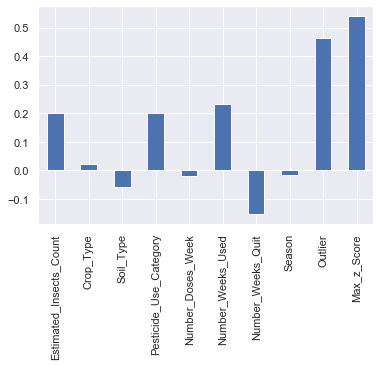

In [17]:
data.drop('Crop_Damage',axis=1).corrwith(data['Crop_Damage']).plot(kind='bar')
plt.show()

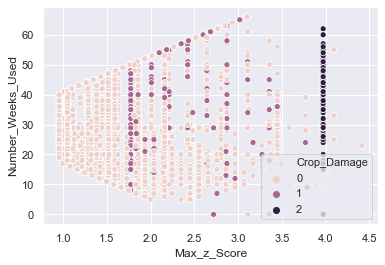

In [18]:
sns.set()
sns.scatterplot(data['Max_z_Score'],data['Number_Weeks_Used'],hue=data['Crop_Damage'])
plt.show()

#### No type 1 bellow Max_z_score of 1.7. Let's put that information to use.

In [19]:
semi_outlier=[1 if (i>1.75 and i<3.8) else 0 for i in z_score_row_wise_max]
data['Semi_Outlier']=semi_outlier

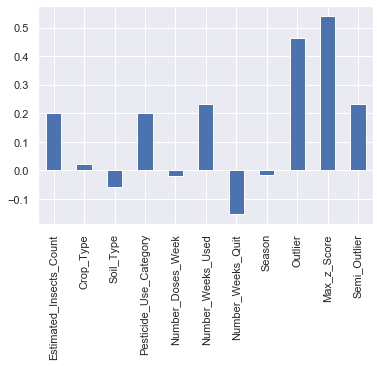

In [20]:
data.drop('Crop_Damage',axis=1).corrwith(data['Crop_Damage']).plot(kind='bar')
plt.show()

In [21]:
y=data['Crop_Damage']
x=data.drop(['Crop_Damage'],axis=1)

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
from sklearn.neighbors import KNeighborsClassifier
knc=KNeighborsClassifier()
from sklearn.neural_network import MLPClassifier
nn=MLPClassifier(hidden_layer_sizes=(25,5),max_iter=1000)
lr=LogisticRegression(max_iter=1000)

In [26]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
x=ss.fit_transform(x)

In [27]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.20)
models=[lr,tree,nb,knc,nn]
for model in models:
    model.fit(X_train,y_train)
    print('---'*30,'\n',model,'\n','---'*30)
    print(model.score(X_test,y_test))
    print(confusion_matrix(model.predict(X_test),y_test))
    print(classification_report(model.predict(X_test),y_test))

------------------------------------------------------------------------------------------ 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
 ------------------------------------------------------------------------------------------
0.9010869565217391
[[749  61   0]
 [ 30  63   0]
 [  0   0  17]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       810
           1       0.51      0.68      0.58        93
           2       1.00      1.00      1.00        17

    accuracy                           0.90       920
   macro avg       0.82      0.87      0.84       920
weighted avg       0.92      0.90      0.91       920

-----------------------------------------

In [31]:
for model in models:
    print('---'*30,'\n',model,'\n','---'*30)
    scores=cross_val_score(model,x,y,cv=5)
    print(scores)
    print(np.mean(scores))

------------------------------------------------------------------------------------------ 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
 ------------------------------------------------------------------------------------------
[0.925      0.86847826 0.89565217 0.89565217 0.89118607]
0.895193736102569
------------------------------------------------------------------------------------------ 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min

#### We want a model which can predict class_0 like logistic regrassion and class_1 like Gaussian NB; we can try stacking.

In [28]:
from sklearn.ensemble import StackingClassifier
good_performing_models=[('tree',DecisionTreeClassifier()),('nb',GaussianNB()),('knc',KNeighborsClassifier()),('nn',MLPClassifier(hidden_layer_sizes=(25,5),max_iter=1000)),('lr',LogisticRegression(max_iter=1000))]
level_0=good_performing_models
level_1=DecisionTreeClassifier()
model_1 = StackingClassifier(estimators=level_0, final_estimator=level_1)
model_1.fit(X_train,y_train)
print('---'*30,'\n',model_1,'\n','---'*30)
print(model_1.score(X_test,y_test))
print(confusion_matrix(model_1.predict(X_test),y_test))
print(classification_report(model_1.predict(X_test),y_test))

------------------------------------------------------------------------------------------ 
 StackingClassifier(cv=None,
                   estimators=[('tree',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
   

In [29]:
level_2=LogisticRegression()
model_2 = StackingClassifier(estimators=level_0, final_estimator=level_2)
model_2.fit(X_train,y_train)
print('---'*30,'\n',model_1,'\n','---'*30)
print(model_2.score(X_test,y_test))
print(confusion_matrix(model_2.predict(X_test),y_test))
print(classification_report(model_2.predict(X_test),y_test))

------------------------------------------------------------------------------------------ 
 StackingClassifier(cv=None,
                   estimators=[('tree',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
   

In [32]:
#[('tree',DecisionTreeClassifier()),('nb',GaussianNB()),('knc',KNeighborsClassifier()),('nn',MLPClassifier(hidden_layer_sizes=(25,5),max_iter=1000)),('lr',LogisticRegression(max_iter=1000))]
level_0=[('tree',DecisionTreeClassifier()),('nb',GaussianNB()),('lr',LogisticRegression(max_iter=1000))]
level_3=LogisticRegression()
model_3 = StackingClassifier(estimators=level_0, final_estimator=level_3)
model_3.fit(X_train,y_train)
print('---'*30,'\n',model_1,'\n','---'*30)
print(model_3.score(X_test,y_test))
print(confusion_matrix(model_3.predict(X_test),y_test))
print(classification_report(model_3.predict(X_test),y_test))

------------------------------------------------------------------------------------------ 
 StackingClassifier(cv=None,
                   estimators=[('tree',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
   

#### So all performs more or less the same with model_1 having a slightly better edge on class_1 precission. Focusing on recall is not that much important as we need to predict crop damage due to pesticide use.

In [34]:
from sklearn.externals import joblib
joblib.dump(model_1,'agriculture.pkl')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['agriculture.pkl']

In [35]:
test=pd.read_excel('test_agriculture.xlsx')

In [36]:
test.drop(['ID'],axis=1,inplace=True)

In [37]:
test.isnull().sum()

Estimated_Insects_Count      0
Crop_Type                    0
Soil_Type                    0
Pesticide_Use_Category       0
Number_Doses_Week            0
Number_Weeks_Used          119
Number_Weeks_Quit            0
Season                       0
dtype: int64

In [38]:
test['Number_Weeks_Used'].fillna(value=test['Number_Weeks_Used'].mean(),inplace=True)
test.isnull().sum()

Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
dtype: int64

In [40]:
cols = test.select_dtypes([np.number]).columns
z_score=abs(zscore(test[cols]))
print(test.shape)
test_final=test.loc[(z_score<3).all(axis=1)]
print(test_final.shape)
z_score_row_wise_max=z_score.max(axis=1)
outlier=[1 if i>3 else 0 for i in z_score_row_wise_max]
test['Outlier']=outlier
test['Max_z_Score']=z_score_row_wise_max

(1199, 8)
(1160, 8)


In [41]:
semi_outlier=[1 if (i>1.75 and i<3.8) else 0 for i in z_score_row_wise_max]
test['Semi_Outlier']=semi_outlier

In [42]:
test_f=ss.fit_transform(test)

In [44]:
result=model_1.predict(test_f)

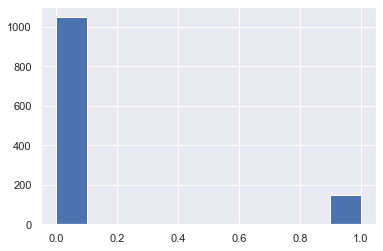

In [45]:
plt.hist(result)
plt.show()

In [46]:
output=pd.DataFrame(result)
output.to_csv('output.csv')